In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import pandas as pd
import io #Used as buffer
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
path= Path(f'../../data/cluster_results')

In [3]:
def read_csv(f):
    df = pd.read_csv(f).mean()
    df['std'] = pd.read_csv(f).std().iloc[0] #remove this line to remove std from table

    df['experiment'] = f.parent.parent.parent.name
    df['function'] = f.parent.parent.name
    name = f.parent.name
    #print(name)
    df['freq'] = float(name[4:].split('n')[0])
    #print(df['freq'])
#     df['method'] = f.name.split('_')[0]
    df['method'] = f.name.split('_')[0]+'_'+f.name.split('_')[1]
#     df['nn_p']=name[14:].split('n')[0] 
    df['nn_p'] = name.split('nn_p')[1].split('n')[0]
    return df

measure_name=['mof','sr','arr','nfe','nn_time']
index_measure=0

In [ ]:
files = list(f for f in path.glob(f'exp*/*/freq{freq}nn_w5nn_p*nn_s3nn_tw5nn_bs4nn_epoch3/*{m}.csv') if replace_mech in f.name) #path.glob(f'exp*/*/freq1*nn_s*nn_tw*bs*/*{m}.csv')

In [4]:
def get_data(freq, replace_mech):
    m = measure_name[index_measure]
    files = list(f for f in path.glob(f'exp*/*/freq{freq}nn_w5nn_p*nn_s3nn_tw5nn_bs4nn_epoch3/*{m}.csv') if replace_mech in f.name) #path.glob(f'exp*/*/freq1*nn_s*nn_tw*bs*/*{m}.csv')
    files=[o for o in files if 'nn_p5' not in o.parent.name]
    #print(files)
    df = pd.DataFrame([read_csv(f) for f in files])
    # data = pd.pivot_table(df, index=['experiment','function'], columns='method', values=m) #,'freq' later for adding frequency experiment
    data = pd.pivot_table(df, index=['experiment','function','freq', 'nn_p' ],columns='method' ) #,'freq' later for adding frequency experiment, ,values=m 'ns','tw', 'bs','epochs'
    data.style.format("{:,.2f}")
    d = data.reset_index()
    d.columns = ['experiment', 'function', 'freq', 'nn_p', 'NNnorm', 'NNnorm_std']
    d.head(2)
    d1 = d.melt(['experiment','function','freq','nn_p'], value_vars=['NNnorm'],
                var_name='method', value_name='mof')
    d2 = d.melt(['experiment','function','freq', 'nn_p'], value_vars=['NNnorm_std'],
                var_name='method', value_name='mof_std')
    d2.method = d2.method.str.replace('_std', '')
    d = d1.merge(d2)
    d['function'] = d['function'].str.title()
    return d

In [5]:
freq = 1
replace_mech = 'NNnorm_Worst'
d = get_data(freq, replace_mech)
d.head()

,experiment,function,freq,nn_p,method,mof,mof_std
0,exp1,Rastrigin,1.0,1,NNnorm,16.799697,0.361331
1,exp1,Rastrigin,1.0,3,NNnorm,16.486775,0.152392
2,exp1,Rastrigin,1.0,7,NNnorm,16.282586,0.303976
3,exp1,Rastrigin,1.0,9,NNnorm,15.050083,3.053362
4,exp1,Rosenbrock,1.0,1,NNnorm,5334.109824,290.594304


# Past things

In [157]:
m = measure_name[index_measure]

files = list(f for f in path.glob(f'exp*/*/freq{freq}nn_w5nn_p*nn_s3nn_tw5nn_bs4nn_epoch3/*{m}.csv') if 'NNnorm_Worst' in f.name) #path.glob(f'exp*/*/freq1*nn_s*nn_tw*bs*/*{m}.csv')
files=[o for o in files if 'nn_p5' not in o.parent.name]
#print(files)
df = pd.DataFrame([read_csv(f) for f in files])
# data = pd.pivot_table(df, index=['experiment','function'], columns='method', values=m) #,'freq' later for adding frequency experiment
data = pd.pivot_table(df, index=['experiment','function','freq', 'nn_p' ],columns='method' ) #,'freq' later for adding frequency experiment, ,values=m 'ns','tw', 'bs','epochs'
data.style.format("{:,.2f}")

In [145]:
import altair as alt
alt.renderers.enable('notebook')
# DataFrame we use for plots

d = data.reset_index()
d.columns = ['experiment', 'function', 'freq', 'nn_p', 'NNnorm', 'NNnorm_std']
d.head(2)
d1 = d.melt(['experiment','function','freq','nn_p'], value_vars=['NNnorm'],
            var_name='method', value_name='mof')
d2 = d.melt(['experiment','function','freq', 'nn_p'], value_vars=['NNnorm_std'],
            var_name='method', value_name='mof_std')
d2.method = d2.method.str.replace('_std', '')
d = d1.merge(d2)
d['function'] = d['function'].str.title()
#d.head()

# Plot functions

In [6]:
def plot_experiment(exp, d):
    test = d.query(f"experiment=={exp!r}").copy()  # & freq==1"
    mins = test.groupby('function')['mof'].min()
    test['mof_norm'] = test['mof']
    for k,v in mins.iteritems():
        test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
    #test.head()

    base = alt.Chart(test)
    chart1 = base.mark_bar().encode(
        alt.X('function', title='', sort='descending'),
        alt.Y('mean(mof_norm)',  title=f'{exp} (mof_norm)'),
        alt.Color('nn_p'),
#         alt.Tooltip(['mof_norm','mof','freq','function']),
    ).properties(
        #title=exp,
        width=300
    )
    return chart1

In [12]:
def plot2_experiment(exp, d):
    test = d.query(f"experiment=={exp!r}").copy()  # & freq==1"
    mins = test.groupby('function')['mof'].min()
    test['mof_norm'] = test['mof']
    for k,v in mins.iteritems():
        test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
    #test.head()
    base = alt.Chart(test)
    chart1 = base.mark_bar().encode(
        alt.X('nn_p', title='', axis=None),
        alt.Y('mean(mof_norm)',  title=f'{exp} (MOF_norm)'),
        alt.Color('nn_p',  legend=alt.Legend(title='n_p')),
        alt.Column('function', title='', sort='descending'),
        alt.Tooltip(['mof_norm:Q','mof:Q','freq:Q','function:N']),
    ).properties(
       # title=exp,
        width=50, height=150
    )
    return chart1

In [16]:
def plot3_experiment(exp, d):
    test = d.query(f"experiment=={exp!r}").copy()  # & freq==1"
    mins = test.groupby('function')['mof'].min()
    test['mof_norm'] = test['mof']
    for k,v in mins.iteritems():
        test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
    #test.head()
    base = alt.Chart(test)
    chart1 = base.mark_bar().encode(
        alt.X('nn_p', title='', axis=None),
        alt.Y('mean(mof_norm)',  title=f'{exp} (MOF_norm)'),
        alt.Color('nn_p',  legend=alt.Legend(title='n_p')),
        alt.Tooltip(['mean(mof_norm):Q','freq:Q']),
    ).properties(
        #title=exp,
        width=70, height=100
    )
    return chart1

# show plots

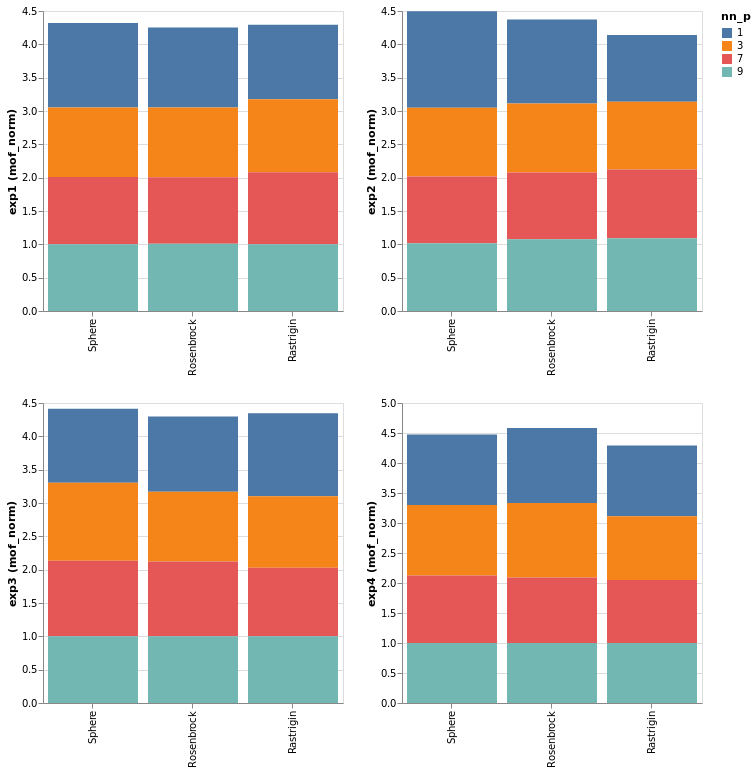

In [9]:
(plot_experiment('exp1',d)|plot_experiment('exp2',d))&(plot_experiment('exp3',d)|plot_experiment('exp4',d))

Plots for Worst freq=0.5


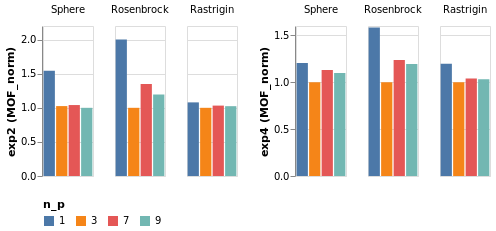

Plots for Random freq=0.5


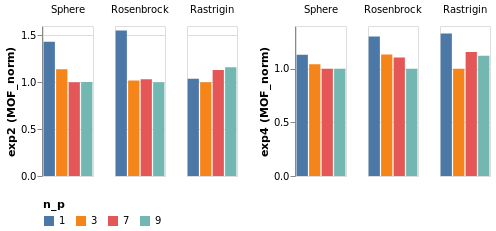

Plots for Worst freq=1


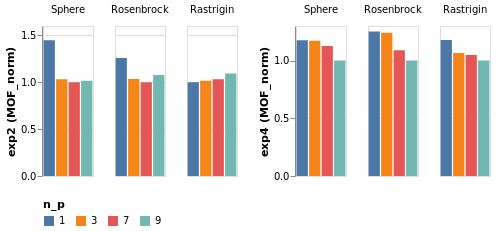

Plots for Random freq=1


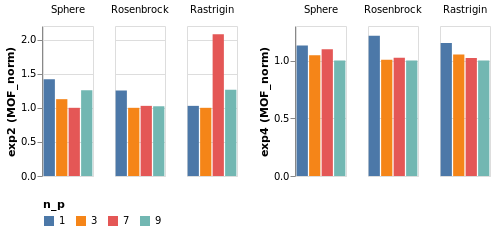

Plots for Worst freq=4


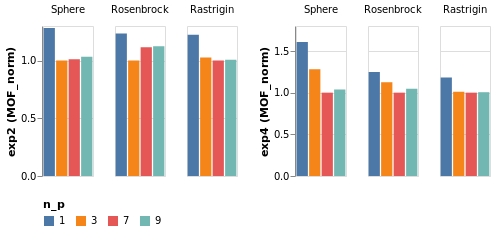

Plots for Random freq=4


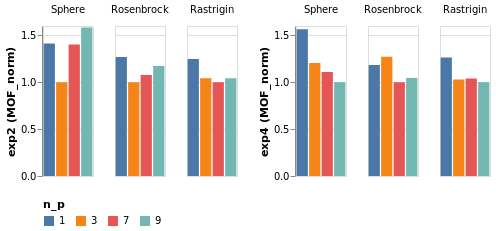

In [13]:
for freq in [0.5,1,4]:
    for replace_mech in ['Worst', 'Random']:
        d = get_data(freq, 'NNnorm_'+replace_mech)
        plot = plot2_experiment('exp2',d)|plot2_experiment('exp4',d)
        plot = plot.configure_legend(orient='bottom')
        freq_lbl = freq if freq > 1 else f'{freq*10:02.0f}'
#         plot.save(str(path/f'nnp{freq_lbl}_{replace_mech}.png'), scale_factor=2)
        print(f'Plots for {replace_mech} freq={freq}')
        display(plot)

Worst


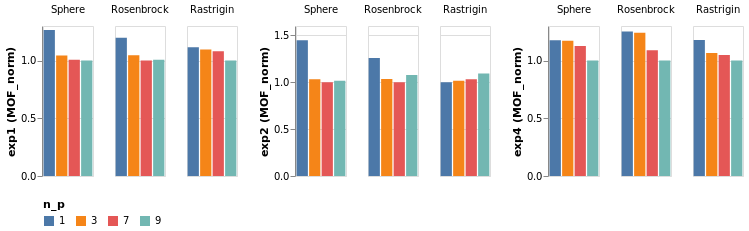

Random


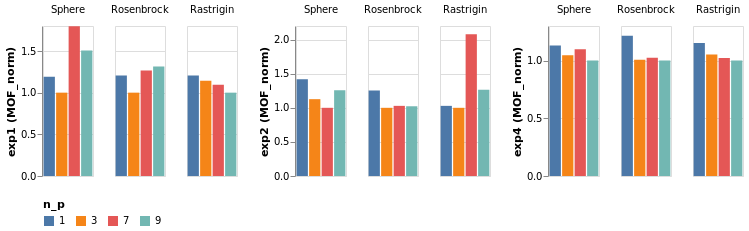

In [33]:
for replace_mech in ['Worst', 'Random']:
    print(replace_mech)
    d = get_data(1, 'NNnorm_'+replace_mech)
    #nnpick=(plot2_experiment('exp1')|plot2_experiment('exp2'))&(plot2_experiment('exp3')|plot2_experiment('exp4'))
    nnpick=plot2_experiment('exp1',d)|plot2_experiment('exp2',d)|plot2_experiment('exp4',d)
    nnpick = nnpick.configure_legend(
        orient='bottom'
    )
    nnpick.save(str(path/f'nnp{freq}_{replace_mech}.png'), scale_factor=2)
    display(nnpick)

In [32]:
# freq = 1
# nnpick=(plot3_experiment('exp1',d)|plot3_experiment('exp2',d))|(plot3_experiment('exp3',d)|plot3_experiment('exp4',d))
# # nnpick=plot3_experiment('exp2')|plot3_experiment('exp4')

# nnpick

In [152]:
#nnpick.save(str(path/f'nnptotal{freq}.png'), scale_factor=2)